In [50]:
import graphviz
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

In [6]:
class Node:
    def __init__(self, feature=None, f_value=None, childs=None, label=None, most_common=None):
        # best feature to split the node
        self.feature = feature
        # value of parent's selected feature
        self.f_value = f_value
        # dictionary of childs
        self.childs = childs
        # label of the node if it is leaf
        self.label = label
        # most common label of the node
        self.most_common = most_common
        
    def is_leaf_node(self):
        return self.label is not None
    
    def plot_node(self, figure, column_labels, parent=None):
        if self.childs is not None:
            for key in self.childs:
                if not self.childs[key].is_leaf_node():
                    figure.edge(str(column_labels[self.feature]), str(column_labels[self.childs[key].feature]), label=str(key))
                    self.childs[key].plot_node(figure, column_labels)
                else:
                    figure.attr('node', shape='box')
                    figure.edge(str(column_labels[self.feature]), str(self.childs[key].label)+', '+str(column_labels[self.feature]), label=str(key))
                    figure.attr('node', shape='ellipse')

In [7]:
class DecisionTree:
    def __init__(self, criterion='entropy', min_samples_split=1):
        # name of the criterion to select best splits
        self.criterion = criterion
        # minimum number of samples to consider it as leaf
        self.min_samples_split=min_samples_split
        # root of the tree
        self.root=None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
    
    def plot_tree(self, column_labels):
        figure = graphviz.Digraph('tree', filename='tree.gv')
        figure.attr('node', shape='ellipse')
        self.root.plot_node(figure, column_labels)
        figure.view()

    def _grow_tree(self, X, y, f_value=None):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(f_value=f_value, label=leaf_value, most_common=leaf_value)

        # find the best split
        best_feature = self._best_split(X, y)

        # create child nodes
        childs = {}
        best_feature_column = X[:, best_feature]
        for v in np.unique(best_feature_column):
            index = np.argwhere(best_feature_column == v).flatten()
            child_X = X[index]
            child_y = y[index]
            childs[v] = self._grow_tree(child_X, child_y, v)
        
        return Node(feature=best_feature, f_value=f_value, childs=childs, most_common=self._most_common_label(y))


    def _best_split(self, X, y):
        if self.criterion == 'entropy':
            best_gain = -1
            split_idx = None
            for feat_idx in range(X.shape[1]):
                X_column = X[:, feat_idx]
                gain = self._information_gain(y, X_column)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
            return split_idx
        
        elif self.criterion == 'gini':
            best_gini = float('inf')
            split_idx = None
            for feat_idx in range(X.shape[1]):
                X_column = X[:, feat_idx]
                gini = self._gini_split(y, X_column)
                if gini < best_gini:
                    best_gini = gini
                    split_idx = feat_idx
            return split_idx

    def _information_gain(self, y, X_column):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        childs_idx = self._split(X_column)
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        information_gain = parent_entropy
        for ch_id in childs_idx:
            n_ch = len(ch_id)
            information_gain -= (n_ch / n) * self._entropy(y[ch_id])
            
        return information_gain

    def _split(self, X_column):
        splits = []
        for v in np.unique(X_column):
            splits.append(np.argwhere(X_column == v).flatten())
        return splits

    def _entropy(self, y):
        count = Counter(y)
        return -np.sum([count[i]/len(y) * np.log2(count[i]/len(y)) for i in count])

    def _gini_split(self, y, X_column):
        # create children
        childs_idx = self._split(X_column)
        # calculate Gini split
        n = len(y)
        return np.sum([(len(ch_id)/n) * self._gini_index(y[ch_id]) for ch_id in childs_idx])
            
    
    def _gini_index(self, y):
        count = Counter(y)
        return 1 - np.sum([(count[i]/len(y)) ** 2 for i in count])
    
    
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.label
        
        if x[node.feature] in node.childs:
            return self._traverse_tree(x, node.childs[x[node.feature]])
        else:
            return node.most_common
        

# Test Bed

In [ ]:
data = {
    'alt': ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes'],
    'bar': ['No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'fri': ['No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes'],
    'hun': ['Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'pat': ['Some', 'Full', 'Some', 'Full', 'Full', 'Some', 'None', 'Some', 'Full', 'Full', 'None', 'Full'],
    'price': ['$$$', '$', '$', '$', '$$$', '$$', '$', '$$', '$', '$$$', '$', '$'],
    'rain': ['No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No'],
    'res': ['Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No'],
    'type': ['French', 'Thai', 'Burger', 'Thai', 'French', 'Italian', 'Burger', 'Thai', 'Burger', 'Italian', 'Thai', 'Burger'],
    'est': ['0-10', '30-60', '0-10', '10-30', '>60', '0-10', '0-10', '0-10', '>60', '10-30', '0-10', '30-60'],
    'will_wait': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes']
}
df = pd.DataFrame(data)
df

In [ ]:
def traverse(root, depth=0, his=[]):
    if root.feature is not None:
        if depth < len(his):
            his[depth].append((root.f_value, list(df.columns)[root.feature]))
        else:
            his.append([(root.f_value, list(df.columns)[root.feature])])
    else:
        if depth < len(his):
            his[depth].append((root.f_value, root.label))
        else:
            his.append([(root.f_value, root.label)])
    
    if root.childs is not None:
        for child_key in root.childs:
            his = traverse(root.childs[child_key], depth+1, his=his)
    
    return his

In [ ]:
tree = DecisionTree(criterion='gini')
tree.fit(df.to_numpy()[:, :-1], df.to_numpy()[:, -1])

In [ ]:
tree.plot_tree(list(df.columns))

In [61]:
def evaluation(y_pred, y, pos_label):
    acc = accuracy_score(y_pred, y)
    prec = precision_score(y_pred, y, pos_label=pos_label)
    rec = recall_score(y_pred, y, pos_label=pos_label)
    f1 = f1_score(y_pred, y, pos_label=pos_label)
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    
    print(f'Accuracy={round(acc, ndigits=4)}, Precision={round(prec, ndigits=4)}, Recall={round(rec, ndigits=4)}, F1={round(f1, ndigits=4)}')
    plt.figure()
    disp.plot()
    plt.show()

# Cancer dataset

In [63]:
df = pd.read_csv('part2.csv').iloc[:, 1:-1]
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Using `cut`

### `entropy` criterion

Accuracy=0.9211, Precision=0.9706, Recall=0.8049, F1=0.88


<Figure size 432x288 with 0 Axes>

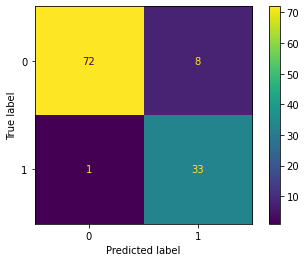

Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


<Figure size 432x288 with 0 Axes>

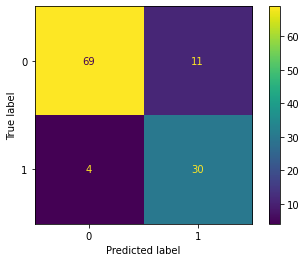

Accuracy=0.9211, Precision=0.9118, Recall=0.8378, F1=0.8732


<Figure size 432x288 with 0 Axes>

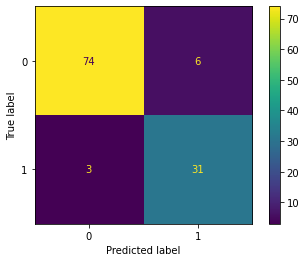

Accuracy=0.8684, Precision=0.8235, Recall=0.7568, F1=0.7887


<Figure size 432x288 with 0 Axes>

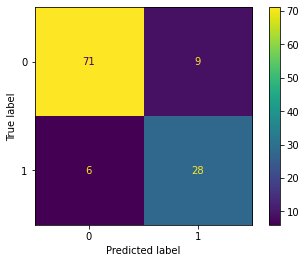

Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


<Figure size 432x288 with 0 Axes>

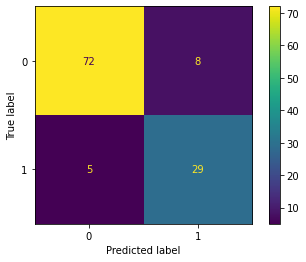

Accuracy=0.8596, Precision=0.8235, Recall=0.7368, F1=0.7778


<Figure size 432x288 with 0 Axes>

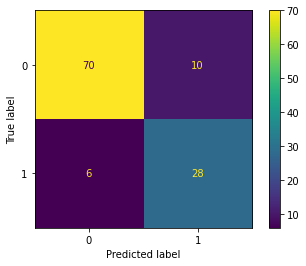

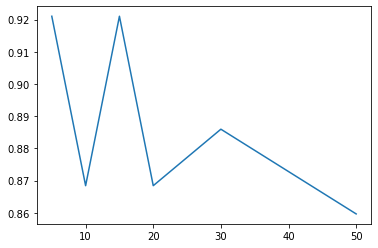

In [64]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.cut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTree()
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    y_pred = my_tree.predict(x_test.to_numpy())
    evaluation(y_pred, y_test, pos_label='M')
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
plt.plot(values, acc_history)

### `gini` criterion

Accuracy=0.9211, Precision=0.9706, Recall=0.8049, F1=0.88


<Figure size 432x288 with 0 Axes>

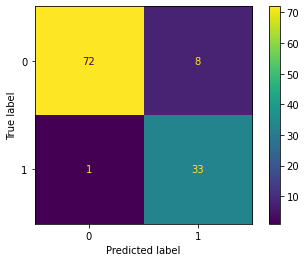

Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


<Figure size 432x288 with 0 Axes>

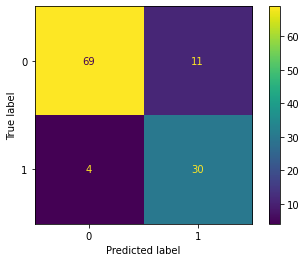

Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


<Figure size 432x288 with 0 Axes>

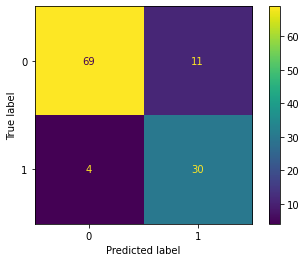

Accuracy=0.8684, Precision=0.8235, Recall=0.7568, F1=0.7887


<Figure size 432x288 with 0 Axes>

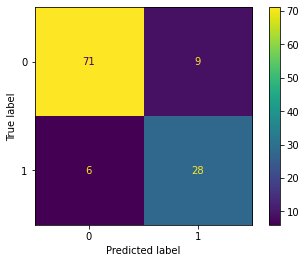

Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


<Figure size 432x288 with 0 Axes>

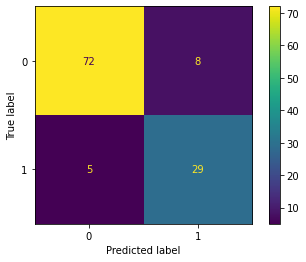

Accuracy=0.8596, Precision=0.8235, Recall=0.7368, F1=0.7778


<Figure size 432x288 with 0 Axes>

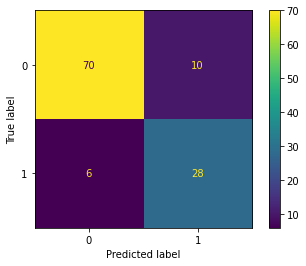

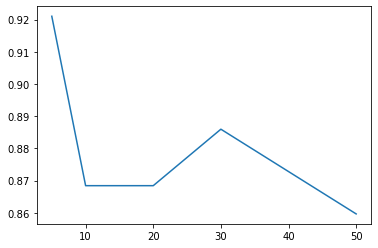

In [65]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.cut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTree(criterion='gini')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    y_pred = my_tree.predict(x_test.to_numpy())
    evaluation(y_pred, y_test, pos_label='M')
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
plt.plot(values, acc_history)

# Using `qcut`

### `entropy` criterion

Accuracy=0.886, Precision=1.0, Recall=0.7234, F1=0.8395


<Figure size 432x288 with 0 Axes>

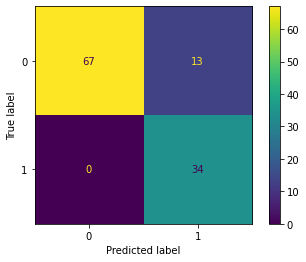

Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


<Figure size 432x288 with 0 Axes>

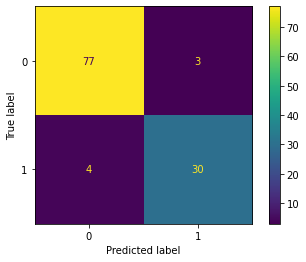

Accuracy=0.8772, Precision=0.8529, Recall=0.7632, F1=0.8056


<Figure size 432x288 with 0 Axes>

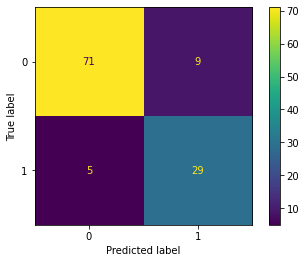

Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


<Figure size 432x288 with 0 Axes>

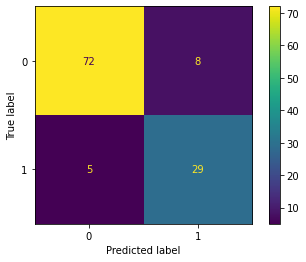

Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


<Figure size 432x288 with 0 Axes>

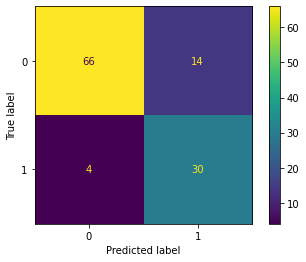

Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


<Figure size 432x288 with 0 Axes>

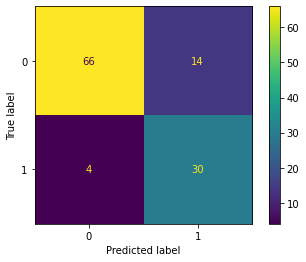

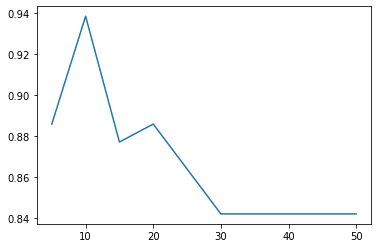

In [66]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTree()
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    y_pred = my_tree.predict(x_test.to_numpy())
    evaluation(y_pred, y_test, pos_label='M')
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
plt.plot(values, acc_history)

### `gini` criterion

Accuracy=0.8947, Precision=1.0, Recall=0.7391, F1=0.85


<Figure size 432x288 with 0 Axes>

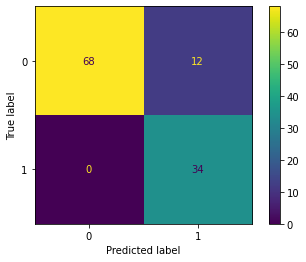

Accuracy=0.9386, Precision=0.8824, Recall=0.9091, F1=0.8955


<Figure size 432x288 with 0 Axes>

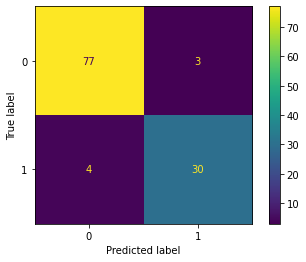

Accuracy=0.8772, Precision=0.8529, Recall=0.7632, F1=0.8056


<Figure size 432x288 with 0 Axes>

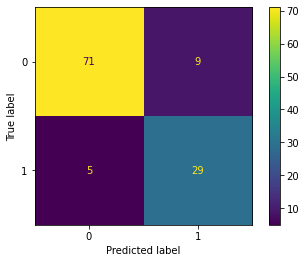

Accuracy=0.886, Precision=0.8529, Recall=0.7838, F1=0.8169


<Figure size 432x288 with 0 Axes>

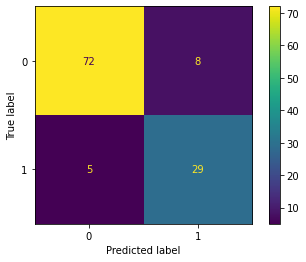

Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


<Figure size 432x288 with 0 Axes>

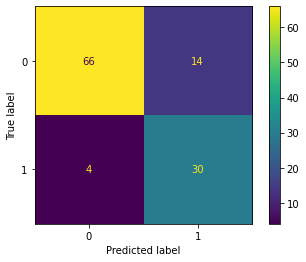

Accuracy=0.8421, Precision=0.8824, Recall=0.6818, F1=0.7692


<Figure size 432x288 with 0 Axes>

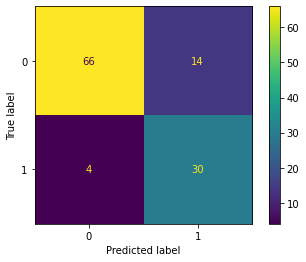

[0.8947368421052632, 0.9385964912280702, 0.8771929824561403, 0.8859649122807017, 0.8421052631578947, 0.8421052631578947]


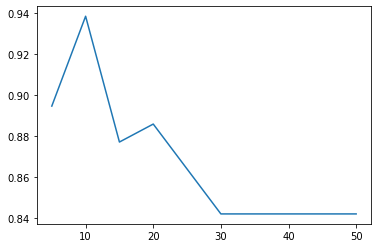

In [62]:
values = [5, 10, 15, 20, 30, 50]
acc_history = []

for v in values:
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    bins = []
    for c in x_train.columns:
        x_train[c], c_bins = pd.qcut(x_train[c], v, retbins=True)
        bins.append(c_bins)

    my_tree = DecisionTree(criterion='gini')
    my_tree.fit(x_train.to_numpy(), y_train.to_numpy())
    
    for idx, c in enumerate(x_test.columns):
        x_test[c] = pd.cut(x_test[c], bins[idx])
        
    y_pred = my_tree.predict(x_test.to_numpy())
    evaluation(y_pred, y_test, pos_label='M')
    acc_history.append(accuracy_score(y_pred, y_test.to_numpy()))
    
plt.figure()
plt.plot(values, acc_history)

# Using sort and cut algorithm

In [43]:
def sort_cut(column, label):
    bins = []
    array = np.stack([column, label]).T
    array = array[array[:, 0].argsort()]
    bins.append(array[0, 0] - 1e-10)
    current_class = array[0, 1]
    for i in range(1, array.shape[0]):
        if array[i, 1] != current_class:
            bins.append((array[i, 0] + array[i - 1, 0]) / 2)
            current_class = array[i, 1]
    bins.append(array[-1, 0] + 1e-10)
    bins = np.unique(bins)
    return bins

### `entropy` criterion

Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


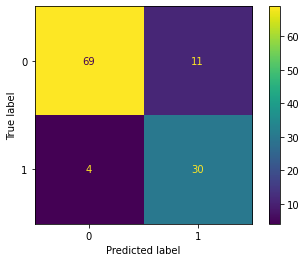

In [56]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

bins = []
for c in x_train.columns:
    bins.append(sort_cut(x_train[c], y_train))
    x_train[c] = pd.cut(x_train[c], bins[-1])

my_tree = DecisionTree()
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

y_pred = my_tree.predict(x_test.to_numpy())

evaluation(y_pred, y_test, pos_label='M')

### `gini` criterion

Accuracy=0.8684, Precision=0.8824, Recall=0.7317, F1=0.8


<Figure size 432x288 with 0 Axes>

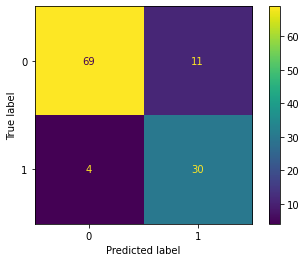

In [67]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

bins = []
for c in x_train.columns:
    bins.append(sort_cut(x_train[c], y_train))
    x_train[c] = pd.cut(x_train[c], bins[-1])

my_tree = DecisionTree(criterion='gini')
my_tree.fit(x_train.to_numpy(), y_train.to_numpy())

for idx, c in enumerate(x_test.columns):
    x_test[c] = pd.cut(x_test[c], bins[idx])

y_pred = my_tree.predict(x_test.to_numpy())

evaluation(y_pred, y_test, pos_label='M')

# Sklearn results

### `entropy` criterion

Accuracy=0.8772, Precision=0.9412, Recall=0.7273, F1=0.8205


<Figure size 432x288 with 0 Axes>

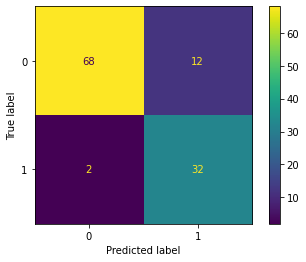

In [68]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
    
x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=4)

sk_tree = DecisionTreeClassifier(criterion='entropy')
sk_tree.fit(x_train, y_train)
y_pred = sk_tree.predict(x_test)
evaluation(y_pred, y_test, pos_label='M')

### `gini` criterion

Accuracy=0.9386, Precision=1.0, Recall=0.8293, F1=0.9067


<Figure size 432x288 with 0 Axes>

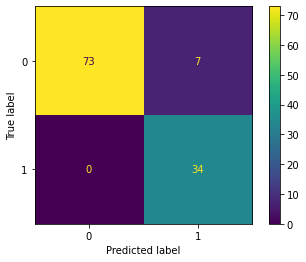

In [69]:
sk_tree = DecisionTreeClassifier(criterion='gini')
sk_tree.fit(x_train, y_train)
y_pred = sk_tree.predict(x_test)
evaluation(y_pred, y_test, pos_label='M')